<a href="https://colab.research.google.com/github/Louisfhgr/Dash.py/blob/master/BA_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.0 MB/s eta 0:00:00


In [2]:
import math
from abc import ABC, abstractmethod
from datetime import datetime

import geopy.distance
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from pyproj import Transformer
from scipy.signal import savgol_filter


class PhysicsComputer(ABC):
    """ Contains methods that are common for both SkiAlpine and SkiCrossCountry Class. It's the abstract base class
    that not will be initiated but that will be the blueprint for SkiAlpine and SkiCrossCountry classes."""

    DEFAULT_CONFIG = {
        'savitzky_golay': {
            'window_size':
                {'none': 11, 'DH': 11, 'SX': 11,'GS': 11, 'SL': 7, 'XC': 151},
            'order':
                {'none': 3, 'DH': 3, 'SX': 3, 'GS': 3, 'SL': 3, 'XC': 3}
        }
    }


    def __init__(self, df: pd.DataFrame, config:dict):
        """
        :param df: pandas DataFrame with raw data
        :param config: config dictionary that sets values for different filters aso.
        """
        self._original = df
        self._df = df
        self.config = config

    @abstractmethod
    def compute(self):
        """ Define method that executes all calculations for either SkiAlpine- or SkiCrossCountry-Instance"""
        pass

    def plot(self, feature: str|list[str] = None, title: str = None) -> go.Figure:
        """ Offers a simple plot-API to visualize a singe feature ort multiple features in time

        :param title: optional plot-title as string
        :param feature: feature to be visualized as string or list of features
        """
        features = []
        if feature is None:
            raise f"Please select a feature from DataFrame!"
        elif isinstance(feature, str) and feature not in self._df.columns:
            raise Exception(f"Feature {feature} not found")
        elif isinstance(feature, str) and feature in self._df.columns:
            features.append(feature)
        elif isinstance(feature, list):
            features = [i for i in feature if i in self._df.columns]
            if len(features) == 0:
                raise Exception(f"Feature {feature} not found")
            elif len(features) != len(feature):
                logger.info(f"Dropped {len(feature)- len(features)} feature(s)")

        if len(features) != 0:
            x = self._df['time'] if 'time' in self._df.columns else self._df.index
            title = dict(text=title if title is not None else f"feature: {','.join(features)}", font=dict(size=28))
            if len(features) > 1:
                fig = go.Figure()
                for i in range(len(features)):
                    fig.add_trace(go.Scatter(x=x, y=self._df[features[i]],
                                             mode='lines',
                                             name=features[i]))
            else:
                fig = px.line(self._df, x=x, y=features[0], title=f'{",".join(features)}'.upper())
            fig.update_layout(template='plotly_white', title=title)
            return fig

    def export_csv(self, path: str) -> None:
        """ Exports calculated data to a .csv-File.

        :param path: output-path as string
        """
        EXPORTED_COLUMNS = ['elevation', 'latitude', 'longitude','tf_id', 'discipline_from_name', 'time', 'date',
                            'x_norm', 'y_norm', 'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
                            'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp', 'v_elevation_sp',
                            'a_elevation_sp', 'k', 'k_xy', 'distance', 'distance_x_y', 'v']
        df = self._df[EXPORTED_COLUMNS].copy()
        df.to_csv(path, index=False)

    @staticmethod
    def _transform_to_x_y(coord1: tuple, coord2: tuple) -> (float, float):
        """ Actually transforms the coordinates x and y
        source: https://chatgpt.com/c/71f7ea04-2b95-4b07-96ee-fc5ccbf41532

        :param coord1: tuple containing latitude and longitude of starting point; exp: (46.5, 8.3)
        :param coord2: tuple containing latitude and longitude of ending point; exp: (46.5, 8.3)
        :return: tuple containing 2 floats with distance in meters between the 2 given coordinates in x and y direction
        """
        utm_zone = math.ceil((coord1[1] + 180) / 6)
        hemisphere = 'N' if coord1[0] >= 0 else 'S'
        wgs84 = 'epsg:4326'
        utm = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = Transformer.from_crs(wgs84, utm)
        x1, y1 = transformer.transform(coord1[0], coord1[1])
        x2, y2 = transformer.transform(coord2[0], coord2[1])
        relative_x = x2 - x1
        relative_y = y2 - y1
        return relative_x, relative_y

    @staticmethod
    def _apply_savitzky_golay(dff: pd.DataFrame, filter_for: tuple, window_size: int, order: int) -> pd.DataFrame:
        """ Applies smoothing with Savitzky-Golay to given columns in pandas DataFrame with certain window_size and order

        :param dff: pandas DataFrame with raw data
        :param filter_for: tuple with column-names in DataFrame as string that should be modified
        :param window_size: length of Savitzky-Golay window as integer
        :param order: order of Savitzky-Golay Filter
        :return: modified pandas DataFrame
        """
        # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        # https://gist.github.com/krvajal/1ca6adc7c8ed50f5315fee687d57c3eb
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

        for item in filter_for:
            if item not in dff.columns:
                continue

            val = dff[item].values
            dff[f"{item}_sp"] = savgol_filter(val, window_size, order)
            dff[f"v_{item}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            dff[f"a_{item}_sp"] = savgol_filter(val, window_size, order, deriv=2)

        return dff

    def _modify_config(self, config: dict=None) -> dict:
        """ Modifies config file with the goal that all needed values are existing. If they do not exist in given config
        discipline specific default values from parent class will be taken, else given values will be taken.

        :param config: optional config dictionary that contains values for different filters and settings.
        :return: modified_config (merged with discipline specific DEFAULT_CONFIG from PhysicsComputer) with all needed values
        """
        def _merge_dicts(config, modified_config):
            for key, value in config.items():
                if isinstance(value, dict) and key in modified_config:
                    _merge_dicts(value, modified_config[key])
                else:
                    if key in modified_config:
                        modified_config[key] = value
            return modified_config

        if 'discipline_from_name' not in self._df.columns:
            raise Exception("discipline_from_name not defined in initial DataFrame!")

        discipline = self._df['discipline_from_name'].iloc[0]

        ws = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('window_size').get(discipline)
        order = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('order').get(discipline)
        modified_config = {}
        modified_config.update({'savitzky_golay': {'window_size': ws, 'order': order}})

        if config is not None:
            modified_config = _merge_dicts(config, modified_config)

        if not 'savitzky_golay' in modified_config or not 'window_size' in modified_config[
            'savitzky_golay'] or not 'order' in modified_config['savitzky_golay']:
            raise Exception(f"Something went wrong with initialisation of config! config: {config}")

        return modified_config

    def _convert_timestamp(self) -> None:
        """ Modifies timestamp from format "%Y%m%dT%H%M%S%f" to separate columns date "%Y-%m-%d" and time "%H:%M:%S."
        as string.
        """
        self._df['datetime'] = pd.to_datetime(self._df['timestamp'], format='%Y%m%dT%H%M%S%f')
        self._df["time"] = self._df["datetime"].dt.strftime("%H:%M:%S.") + (
                    self._df['datetime'].dt.microsecond // 100000).astype(str)
        self._df["date"] = self._df["datetime"].dt.strftime("%Y-%m-%d")
        self._df = self._df.drop(columns=["datetime"])

    def _compute_x_y_z(self) -> None:
        """ Transforms the original coordinates in x and y coordinates in meters and x_rel, y_rel and z_rel as difference
        between 2 measuring points. The starting point for x and y will always be at (0,0)
        """

        self._df = self._df.reset_index(drop=True)
        # transform columns to numeric columns -> all non-numeric values will be set to nan
        self._df['latitude'] = pd.to_numeric(self._df['latitude'], errors="coerce")
        self._df['longitude'] = pd.to_numeric(self._df['longitude'], errors="coerce")
        self._df.dropna(subset=['longitude', 'latitude'], inplace=True)
        # calculates distance im meters from actoil location to starting point
        self._df['x_y_from_origin'] = self._df.apply(
            lambda x: self._transform_to_x_y((self._df.loc[0, 'latitude'], self._df.loc[0, 'longitude']),
                                       (x['latitude'], x['longitude'])), axis=1)
        self._df[['x_norm', 'y_norm']] = pd.DataFrame(self._df['x_y_from_origin'].tolist(), index=self._df.index)
        self._df['x_rel'] = self._df['x_norm'].diff()
        self._df['y_rel'] = self._df['y_norm'].diff()
        if 'z' in self._df.columns:
            self._df['z_rel'] = self._df['z'].diff()
        self._df.drop('x_y_from_origin', axis=1, inplace=True)

    def _compute_savitzky_golay_and_derivatives(self) -> None:
        """ Calls savitzky-golay-filter for defined features
        """
        filter_for =  ('x_norm', 'y_norm', 'elevation')
        self._df = self._apply_savitzky_golay(dff=self._df,
                                        filter_for=filter_for,
                                        window_size=self.config['savitzky_golay']['window_size'],
                                        order=self.config['savitzky_golay']['order'])

    def _compute_k(self) -> None:
        """ Computes 'curvature'
        """
        def _calc_k_3D(row: pd.Series) -> float:
            v = [row['v_x_norm_sp'], row['v_y_norm_sp'], row['v_elevation_sp']]
            a = [row['a_x_norm_sp'], row['a_y_norm_sp'], row['a_elevation_sp']]
            cp = np.cross(v, a)
            l = math.sqrt(cp[0] ** 2 + cp[1] ** 2 + cp[2] ** 2)
            v_sp = math.sqrt(row['v_x_norm_sp'] ** 2 + row['v_y_norm_sp'] ** 2 + row['v_elevation_sp'] ** 2)
            return l / v_sp ** 3

        self._df['k'] = self._df.apply(lambda row: pd.Series(_calc_k_3D(row)), axis=1)

    def _compute_k_xy(self) -> None:
        """ Calculates 'curvature' in 2-dimensional-space (x-y-plane)
        """

        def _calc_k_2D(row: pd.Series) -> float:
            vx, vy = row['v_x_norm_sp'], row['v_y_norm_sp']  # 2D-Geschwindigkeitskomponenten
            ax, ay = row['a_x_norm_sp'], row['a_y_norm_sp']  # 2D-Beschleunigungskomponenten
            cp = vx * ay - vy * ax  # 2D-"Kreuzprodukt" (nur Betrag für xy-Ebene)
            v_sp = math.sqrt(vx ** 2 + vy ** 2) # Betrag der Geschwindigkeit in 2D
            return abs(cp) / v_sp ** 3

        self._df['k_xy'] = self._df.apply(lambda row: pd.Series(_calc_k_2D(row)), axis=1)

    def _compute_distances(self) -> None:
        """ Computes distances between 2 coordinate-points
        """
        # add shifts to x_norm, y_norm, latitude and longitude
        self._df['shifted_x_norm'] = self._df['x_norm'].shift(periods=1)
        self._df['shifted_y_norm'] = self._df['y_norm'].shift(periods=1)
        self._df['shifted_latitude'] = self._df['latitude'].shift(periods=1)
        self._df['shifted_longitude'] = self._df['longitude'].shift(periods=1)

        def _calculate_distance(row: pd.Series) -> float:
            """ Calculation of distance in meters between 2 coordinate points based on original longitude and latitude

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance between last 2 coordinate points in meters
            """

            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            return geopy.distance.geodesic((row['latitude'], row['longitude']),
                                           (row['shifted_latitude'], row['shifted_longitude'])).m

        def _calculate_distance_from_x_y(row: pd.Series) -> float:
            """ Calculation of distance in meters based on transformed x and y (metric) coordinates. This calculation is used
            to validate either coordinate transformation and calculation of distance

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance in [m] between 2 coordinates
            """
            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            distance = math.sqrt(
                (row['x_norm'] - row['shifted_x_norm']) ** 2 + (row['y_norm'] - row['shifted_y_norm']) ** 2)
            return distance

        self._df['distance'] = self._df.apply(_calculate_distance, axis=1)
        self._df['distance_x_y'] = self._df.apply(_calculate_distance_from_x_y, axis=1)

    def _compute_v(self) -> None:
        """ Calculates speed
        """
        def _calculate_time_delta(df: pd.DataFrame) -> pd.DataFrame:
            """ Transforms single columns 'date' and 'time' to a date_time column in the datetime-format with tenth of a second
            ('%Y-%m-%d %H:%M:%S.%f') and adds feature 'time_delta' that is 'date_time' shifted by one period.

            :param df: pandas DataFrame with raw data
            :return: modified pandas DataFrame with added/modified date_time content
            """
            df["date_time"] = df["date"] + " " + df["time"]

            try:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
            except ValueError:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

            df['shifted_date_time'] = df['date_time'].shift(periods=1)
            df.loc[0, 'shifted_date_time'] = df.loc[0, 'date_time']
            df['time_delta'] = df['date_time'] - df['shifted_date_time']
            df['time_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
            return df

        def _calculate_speed(row: pd.Series) -> float:
            """ Calculates the speed in [m/s] based on distance between 2 calculated x and y coordinates and the according
            time-gap between this 2 coordinates

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a speed calculation in [m/s] as float
            """
            if row['time_delta'] == 0:
                return 0
            speed = row['distance_x_y'] / row['time_delta']
            return speed

        self._df = _calculate_time_delta(self._df)
        self._df["v"] = self._df.apply(lambda row: pd.Series(_calculate_speed(row)), axis=1)



In [3]:
import pandas as pd
from loguru import logger



class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config:dict=None):
        """
        :param df: pandas DataFrame with raw values
        :param config: optional config dictionary that sets values for different filters aso.
        """
        self._df = df
        config = self._modify_config(config)
        super().__init__(df, config)

    @staticmethod
    def _compute_xc_specific_physical_size() -> None:
        """ Computes cross-country-specific physical sizes (at the moment none).
        """
        logger.info("xc specific")

    def compute(self):
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()
        return self._df


In [4]:
from google.colab import files
uploaded = files.upload() # Rohdaten nadine

Saving Goms_2024-01-27_nadine_faehndrich_run_1.csv to Goms_2024-01-27_nadine_faehndrich_run_1.csv


In [5]:
df = pd.read_csv("/content/Goms_2024-01-27_nadine_faehndrich_run_1.csv")

In [6]:

xc = SkiCrossCountry(df=df)
df_modified = xc.compute()

2025-03-05 11:02:31.930 | INFO     | __main__:_compute_xc_specific_physical_size:20 - xc specific


In [7]:
df_modified

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_x_norm,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,0.000000,0.000000,46.500480,8.302427,0.379037,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,-0.369094,-0.085640,46.500479,8.302423,0.392572,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,-0.708476,-0.282667,46.500477,8.302418,0.406760,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,-1.017755,-0.546636,46.500475,8.302414,0.466690,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,-16.688972,10.570932,46.500574,8.302209,1.513311,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,-18.030371,9.871584,46.500567,8.302191,0.741562,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,-18.700775,9.555245,46.500564,8.302183,0.734657,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,-19.363507,9.238838,46.500561,8.302174,0.695094,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404


In [8]:
from google.colab import files
uploaded = files.upload() # export_data_transformed / switch drive

Saving export_data_transformed.csv to export_data_transformed.csv


In [9]:
# CSV-Datei laden
df_gears = pd.read_csv("export_data_transformed.csv")

# Nur die Daten für "nadine_faehndrich_run_1" filtern
df_filtered = df_gears[df_gears["name_run"] == "FAEHNDRICH Nadine Run__1"]

<ipython-input-9-efef63adb080>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gears = pd.read_csv("export_data_transformed.csv")


In [10]:
df_modified_gear = df_modified.copy()

df_modified_gear["technic"] = df_modified["time"].map(df_filtered.set_index("time")["technic"])
df_modified_gear["technic"].unique()

array([nan,  3.,  2.,  6.,  5.,  4.])

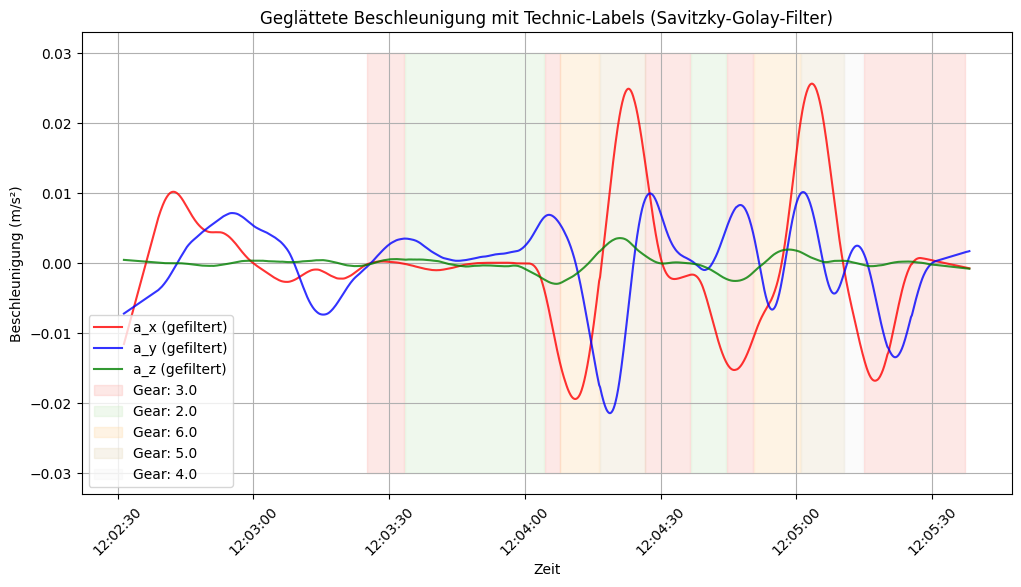

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sicherstellen, dass df_modified_gear die "technic"-Spalte enthält
if "technic" not in df_modified_gear.columns:
    raise ValueError("Die Spalte 'technic' fehlt in df_modified_gear! Stelle sicher, dass sie korrekt hinzugefügt wurde.")

# Zeitachse erstellen
time_series = pd.to_datetime(df_modified_gear["time"], format="%H:%M:%S.%f")  # Zeit in datetime umwandeln

# Gefilterte Beschleunigungen aus df_modified_gear
acc_x = df_modified_gear["a_x_norm_sp"]
acc_y = df_modified_gear["a_y_norm_sp"]
acc_z = df_modified_gear["a_elevation_sp"]


# Technic-Kategorie (Gear) auf numerische Werte mappen
unique_technic = df_modified_gear["technic"].dropna().unique()
technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
technic_values = df_modified_gear["technic"].map(technic_mapping)

# Farben für die verschiedenen Gears definieren
colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))  # Weiche Farben für Hintergrund

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(time_series, acc_x, label="a_x (gefiltert)", alpha=0.8, color="red")
plt.plot(time_series, acc_y, label="a_y (gefiltert)", alpha=0.8, color="blue")
plt.plot(time_series, acc_z, label="a_z (gefiltert)", alpha=0.8, color="green")

# Gears als Hintergrundfarben markieren
for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
    mask = technic_values == idx
    plt.fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")

plt.xlabel("Zeit")
plt.ylabel("Beschleunigung (m/s²)")
plt.title("Geglättete Beschleunigung mit Technic-Labels (Savitzky-Golay-Filter)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



